<a href="https://colab.research.google.com/github/OswaldoTrillo/AIProject/blob/main/SCaM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

In [3]:
df = pd.read_csv('SPAM text message 20170820 - Data.csv',delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.index = range(5572)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

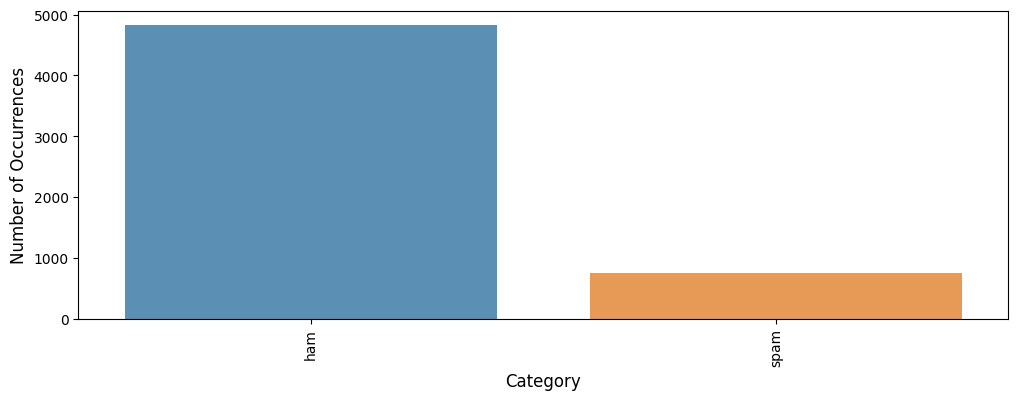

In [17]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
#sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [19]:
def print_message(index):
    example = df[df.index == index][['Message', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

URGENT! You have won a 1 week FREE membership in our Â£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Message: spam


In [21]:
print_message(0)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Message: ham


In [22]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

<ipython-input-22-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [26]:
nltk.download('punkt')

df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-22-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


Found 5572 unique tokens.


In [27]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [28]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['and', 'also', 'i', "'ve", 'sorta', 'blown', 'him', 'off', 'a', 'couple', 'times', 'recently', 'so', 'id', 'rather', 'not', 'tet', 'him', 'out', 'of', 'the', 'blue', 'looking', 'for', 'weed'], tags=['ham']),
       TaggedDocument(words=['mmm', 'thats', 'better', 'now', 'i', 'got', 'a', 'roast', 'down', 'me', '!', 'iâ\x92d', 'b', 'better', 'if', 'i', 'had', 'a', 'few', 'drinks', 'down', 'me', '2', '!', 'good', 'indian', '?'], tags=['ham']),
       TaggedDocument(words=['mm', 'have', 'some', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok'], tags=['ham']),
       ...,
       TaggedDocument(words=['prabha', '..', 'i', "'m", 'soryda', '..', 'realy', '..', 'frm', 'heart', 'i', "'m", 'sory'], tags=['ham']),
       TaggedDocument(words=['nt', 'joking', 'seriously', 'i', 'told'], tags=['ham']),
       TaggedDocument(words=['did', 'he', 'just', 'say', 'somebody', 'is', 'named', 'tampa'], tags=['ham'])],
      dtype=object)

In [30]:
#d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model = Doc2Vec(dm=1, dm_mean=1, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5571/5571 [00:00<00:00, 806518.97it/s]


In [31]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 5571/5571 [00:00<00:00, 1315827.66it/s]


CPU times: user 15 s, sys: 83.7 ms, total: 15.1 s
Wall time: 15.5 s


In [32]:
print(d2v_model)


Doc2Vec<dm/m,d100,n5,w8,s0.001>


In [39]:
#len(d2v_model.wv.vocab)
#len(d2v_model.wv.key_to_index)
len(d2v_model.wv.index_to_key)



9361

In [44]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs_norms):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

NameError: ignored